<a href="https://colab.research.google.com/github/Priyansha-01/DataScience_Pri/blob/master/Capstone_Project_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparison of High-rated Restaurants in Raleigh and Charlotte

## **Introduction**:
The city of Raleigh, NC and Charlotte, NC have amazing restaurants of different types. These cities are major cities of NC. Comparison between these two cities is being made to see best places to go to in both cities and what type of restaurant are popular in both cities. 


## **Business Problem**:
Analysis is done based on Foursquare likes, restaurant category and geographic location data for restaurants in Charlotte and Raleigh. Then with the help of visualization and cluster analysis will discover category popularity in both cities and their specialities based on Foursquare user feedback.

## **About Data**
The Foursquare API is used to pull the following location data on restaurants in Raleigh, NC and Charlotte, NC:
- Venue Name
- Venue ID
- Venue Location
- Venue Category
- No. of Likes

## **Data Acquisition Approach**

For Data Acquisition, Geolocator latitude and longitude coordinates for Raleigh, NC and Charlotte, NC is used. Then with the help of Foursquare API I extracted list of all venues in Raleigh, NC and Charlotte, NC and filtered for venues of category Restaurant.

**Algorithm Used:**

Used gathered data to create a k-means clustering that groups restaurants into different clusters so that comparison can be made to see which type is popular and which restaurants are the best to eat at in Raleigh and Charlotte. 

## Importing Libraries

In [0]:
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json 
from geopy.geocoders import Nominatim 
import requests 
from pandas.io.json import json_normalize 
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium 
from urllib.request import urlopen
from bs4 import BeautifulSoup
import numpy as np
print('Libraries imported.')

Libraries imported.


**Extracting Geographical coordinate for Charlotte and Raleigh**

In [0]:
address_c = 'Charlotte North Carolina'
address_r = 'Raleigh North Carolina'
geolocator = Nominatim()
location_c = geolocator.geocode(address_c)
location_r = geolocator.geocode(address_r)
latitude_c = location_c.latitude
longitude_c = location_c.longitude
latitude_r = location_r.latitude
longitude_r = location_r.longitude
print('The geograpical coordinate of Charlotte are {}, {}.'.format(latitude_c, longitude_c))
print('The geograpical coordinate of Raleigh are {}, {}.'.format(latitude_r, longitude_r))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.22.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinate of Charlotte are 35.2270869, -80.8431268.
The geograpical coordinate of Raleigh are 35.7803977, -78.6390989.


**Accessing Foursquare API by my information.**

In [0]:
CLIENT_ID = '4TP5THCRKCPKNM3IRLBQO0PP2GXRJ0IIMZWLBZAMGDZ3Z0AO' 
CLIENT_SECRET = 'OQ4YZ1PVSDJDQKZYLRYYEC2H3AAU5Q3SARJVVGG1B1RI2DVR' 
VERSION = '20180605' 

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: 4TP5THCRKCPKNM3IRLBQO0PP2GXRJ0IIMZWLBZAMGDZ3Z0AO
CLIENT_SECRET:OQ4YZ1PVSDJDQKZYLRYYEC2H3AAU5Q3SARJVVGG1B1RI2DVR


**Creating a URL for all of the venues in Charlotte and Raleigh**

In [0]:
LIMIT = 1000 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

# create URL for Charlotte
url_c = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_c, 
    longitude_c, 
    radius, 
    LIMIT)
url_c

'https://api.foursquare.com/v2/venues/explore?&client_id=4TP5THCRKCPKNM3IRLBQO0PP2GXRJ0IIMZWLBZAMGDZ3Z0AO&client_secret=OQ4YZ1PVSDJDQKZYLRYYEC2H3AAU5Q3SARJVVGG1B1RI2DVR&v=20180605&ll=35.2270869,-80.8431268&radius=1000&limit=1000'

In [0]:
# create URL
url_r = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_r, 
    longitude_r, 
    radius, 
    LIMIT)
url_r

'https://api.foursquare.com/v2/venues/explore?&client_id=4TP5THCRKCPKNM3IRLBQO0PP2GXRJ0IIMZWLBZAMGDZ3Z0AO&client_secret=OQ4YZ1PVSDJDQKZYLRYYEC2H3AAU5Q3SARJVVGG1B1RI2DVR&v=20180605&ll=35.7803977,-78.6390989&radius=1000&limit=1000'

**Requesting JSON file for the venues URL of Raleigh and Charlotte using beautiful soup library**

In [0]:
results_c = requests.get(url_c).json()

In [0]:
results_r = requests.get(url_r).json()

**Extracting data from Foursquare into a dataframe.**

In [0]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

**Pulling the data from the Foursquare API for Raleigh and Charlotte  and filtering the category for each row**

In [0]:

venues_c = results_c['response']['groups'][0]['items']
nearby_venues_c = json_normalize(venues_c)
filtered_columns_c = ['venue.name', 'venue.id', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues_c
nearby_venues_char =nearby_venues_c.loc[:, filtered_columns_c]


nearby_venues_char['venue.categories'] = nearby_venues_c.apply(get_category_type, axis=1)



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


In [0]:
nearby_venues_char.head()

,venue.name,venue.id,venue.categories,venue.location.lat,venue.location.lng
0,Blumenthal Performing Arts Center,4bad5829f964a52071483be3,Performing Arts Venue,35.227930,-80.841951
1,Belk Theater,4b058640f964a520495a22e3,Concert Hall,35.227711,-80.841663
2,The Capital Grille,4b05863ef964a520f45922e3,American Restaurant,35.228216,-80.841974
3,The Punch Room,549af5b3498e3a660685323b,Hotel Bar,35.226354,-80.841747
4,Dandelion Market,4b466381f964a5206f1f26e3,Tapas Restaurant,35.228656,-80.842479


In [0]:

venues_r = results_r['response']['groups'][0]['items']
nearby_venues_r = json_normalize(venues_r)
filtered_columns_r = ['venue.name', 'venue.id', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues_r
nearby_venues_raleigh =nearby_venues_r.loc[:, filtered_columns_r]


nearby_venues_raleigh['venue.categories'] = nearby_venues_r.apply(get_category_type, axis=1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


In [0]:
nearby_venues_raleigh.head()

,venue.name,venue.id,venue.categories,venue.location.lat,venue.location.lng
0,North Carolina Museum of Natural Sciences,4ad4c009f964a520eeec20e3,Science Museum,35.782217,-78.639375
1,North Carolina Museum of History,4ad4c009f964a520edec20e3,History Museum,35.781516,-78.638747
2,Gallo Pelón,53c2e7a1498e06db62294821,Cocktail Bar,35.779320,-78.638517
3,Nature Research Center,4e00a3737d8beaa1649d0690,Science Museum,35.782486,-78.640745
4,Raleigh Raw,56d20a97498e40011a57fbaa,Juice Bar,35.778308,-78.639610


**Venues term was removed from column names**

In [0]:
nearby_venues_char.columns = [col.split(".")[-1] for col in nearby_venues_char.columns]
nearby_venues_raleigh.columns = [col.split(".")[-1] for col in nearby_venues_raleigh.columns]
nearby_venues_char.head()

,name,id,categories,lat,lng
0,Blumenthal Performing Arts Center,4bad5829f964a52071483be3,Performing Arts Venue,35.227930,-80.841951
1,Belk Theater,4b058640f964a520495a22e3,Concert Hall,35.227711,-80.841663
2,The Capital Grille,4b05863ef964a520f45922e3,American Restaurant,35.228216,-80.841974
3,The Punch Room,549af5b3498e3a660685323b,Hotel Bar,35.226354,-80.841747
4,Dandelion Market,4b466381f964a5206f1f26e3,Tapas Restaurant,35.228656,-80.842479


In [0]:
nearby_venues_raleigh.head()

,name,id,categories,lat,lng
0,North Carolina Museum of Natural Sciences,4ad4c009f964a520eeec20e3,Science Museum,35.782217,-78.639375
1,North Carolina Museum of History,4ad4c009f964a520edec20e3,History Museum,35.781516,-78.638747
2,Gallo Pelón,53c2e7a1498e06db62294821,Cocktail Bar,35.779320,-78.638517
3,Nature Research Center,4e00a3737d8beaa1649d0690,Science Museum,35.782486,-78.640745
4,Raleigh Raw,56d20a97498e40011a57fbaa,Juice Bar,35.778308,-78.639610


**Finding a list of unique categories from the API**

In [0]:
print(nearby_venues_char['categories'].unique())
print(nearby_venues_raleigh['categories'].unique())

['Performing Arts Venue' 'Concert Hall' 'American Restaurant' 'Hotel Bar'
 'Tapas Restaurant' 'Italian Restaurant' 'Steakhouse'
 'New American Restaurant' 'Theater' 'Burger Joint' 'Shopping Mall'
 'Gym / Fitness Center' 'Pizza Place' 'Science Museum' 'Café' 'Creperie'
 'Park' 'Gym' 'Bakery' 'Southern / Soul Food Restaurant' 'Restaurant'
 'Irish Pub' 'Burrito Place' 'Souvenir Shop' 'Hotel' 'Lounge'
 'Sandwich Place' 'Sports Bar' 'Basketball Stadium' 'Seafood Restaurant'
 'Coffee Shop' 'Farmers Market' 'Neighborhood' 'French Restaurant' 'Plaza'
 'Pub' 'Mexican Restaurant' 'History Museum' 'Cocktail Bar' 'Wine Shop'
 'Baseball Stadium' 'Art Museum' 'BBQ Joint' 'Art Gallery' 'Library'
 'Cheese Shop' 'Deli / Bodega' 'Grocery Store' 'Greek Restaurant'
 'Gift Shop' 'Movie Theater' 'Salon / Barbershop' 'Supermarket' 'Museum'
 'Football Stadium' 'Japanese Restaurant' 'Hot Dog Joint']
['Science Museum' 'History Museum' 'Cocktail Bar' 'Juice Bar'
 'Mediterranean Restaurant' 'Event Space' 'Mexican

**Filtering out the data having cateogory of Restaurants for Charlotter and Raleigh**

In [0]:

Restaurant_list = ['American Restaurant','Italian Restaurant','Tapas Restaurant','Restaurant','Thai Restaurant','New American Restaurant',
                   'Southern / Soul Food Restaurant','Seafood Restaurant','Mexican Restaurant','Mediterranean Restaurant','Asian Restaurant',
                   'Sushi Restaurant','Fast Food Restaurant','French Restaurant','Chinese Restaurant',
                   'Korean Restaurant','Vegetarian / Vegan Restaurant' ,'Greek Restaurant','Cuban Restaurant','French Restaurant']
                   


nearby_venues_char = nearby_venues_char.copy()
nearby_venues_raleigh = nearby_venues_raleigh.copy()


nearby_venues_char = nearby_venues_char[nearby_venues_char['categories'].isin(Restaurant_list)]

nearby_venues_raleigh = nearby_venues_raleigh[nearby_venues_raleigh['categories'].isin(Restaurant_list)]
nearby_venues_char.shape

(22, 5)

In [0]:
nearby_venues_raleigh.shape

(24, 5)

**Extracting Venue's ID for the restaurant category**

In [0]:
RestaurantId_raleigh = nearby_venues_raleigh['id'].tolist()
print(RestaurantId_raleigh)

['4ad93789f964a520261921e3', '4ad90386f964a5201d1721e3', '4a592915f964a520d6b81fe3', '54a1adbe498e54b4407ce331', '4ee404309911944900b07ad5', '4e091acc1f6e21103396e069', '588663ddd60c8b2e0e1b1527', '4ad90968f964a520651721e3', '51940a5d498e9111bc706456', '590a66230f013c70e0a0c5f1', '58581f96076be1032aaa07f4', '5577a05f498e75efda31c6a9', '527e482c498e9cdc1c97aefc', '4aeb2a4cf964a52033bf21e3', '57f2d3e8498e33363fc556f5', '516798e0e4b0cda68217b5ed', '57a7bf38498ea30d9431bde1', '4ae6edcaf964a5208ea721e3', '4ad9fa9af964a520ab1c21e3', '5916326a396de017a362ff17', '50a5647be4b079eb079361fa', '52251fd611d21c8d037f3127', '4ad4c008f964a520c4ec20e3', '4ae0fa5df964a5203f8421e3']


In [0]:
RestaurantId_char = nearby_venues_char['id'].tolist()
print(RestaurantId_char)

['4b05863ef964a520f45922e3', '4b466381f964a5206f1f26e3', '4e2ffb921838f1c552ca5f70', '4f8b5454e4b00a6263a38774', '4bb14a46f964a520fa893ce3', '4f516ba8e4b063296bf04765', '4bd07af1caff952185dfcef0', '57a56d1f498e5952a14f86f4', '55a42c96498e793e0e13b18c', '5ae7e6746bdee6002c84ed22', '57a85cb7498ebb2205737e6d', '5b639c99cabcff002cbe11b1', '4b05863ef964a520e95922e3', '584365c79850a03d8398144e', '4b05863ff964a520345a22e3', '4f02453e30f899233495e903', '4b2ac7a6f964a52079af24e3', '54ecae87498ec256aee9450d', '4b05863bf964a520775922e3', '4b21405cf964a520033924e3', '4b05863ef964a520f35922e3', '53113efb498e59275ccb1fdd']


**Creating empty list to extract likes from the API corresponding to Venue ID**

In [0]:
#set up to pull the likes from the API based on venue ID

url_list = []
url_list2 = []
like_Charlist = []
like_Raleighlist=[]
json_list = []

In [0]:
for i in RestaurantId_char:
    venue_url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(i, CLIENT_ID, CLIENT_SECRET, VERSION)
    url_list.append(venue_url)
for link in url_list:
    resultChar = requests.get(link).json()
    likesChar = resultChar['response']['likes']['count']
    like_Charlist.append(likesChar)
print(like_Charlist)

[96, 236, 208, 212, 85, 90, 98, 33, 44, 9, 37, 18, 24, 16, 168, 24, 67, 121, 101, 82, 110, 178]


In [0]:
for i in RestaurantId_raleigh:
    venue_url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(i, CLIENT_ID, CLIENT_SECRET, VERSION)
    url_list2.append(venue_url)
for link in url_list2:
    resultRaleigh = requests.get(link).json()
    likesRaleigh = resultRaleigh['response']['likes']['count']
    like_Raleighlist.append(likesRaleigh)
print(like_Raleighlist)

[231, 125, 139, 64, 262, 453, 46, 146, 64, 16, 31, 93, 39, 54, 23, 126, 89, 202, 55, 22, 123, 149, 123, 87]


**Creating new variable in the dataframe containing total no. of likes for each restaurant**

In [0]:
# add in the list of likes
nearby_venues_raleigh['total likes'] = like_Raleighlist
nearby_venues_char['total likes'] = like_Charlist
nearby_venues_char.shape

(22, 6)

In [0]:
nearby_venues_raleigh.shape

(24, 6)

**Descriptive Analysis of obtained dataframe for further analysis of restaurants in Raleigh and Charlotte**

For Raleigh

In [0]:
nearby_venues_raleigh.describe()

,lat,lng,total likes
count,24.000000,24.000000,24.000000
mean,35.777894,-78.640282,115.083333
std,0.002084,0.003674,97.555744
min,35.774581,-78.646640,16.000000
25%,35.776346,-78.643910,52.000000
50%,35.777456,-78.638414,91.000000
75%,35.778702,-78.637916,140.750000
max,35.782864,-78.634479,453.000000


For Charlotte

In [0]:
nearby_venues_char.describe()

,lat,lng,total likes
count,22.000000,22.000000,22.000000
mean,35.227684,-80.843010,93.500000
std,0.002366,0.002264,69.002933
min,35.222547,-80.848767,9.000000
25%,35.226482,-80.844186,34.000000
50%,35.227870,-80.843157,87.500000
75%,35.228629,-80.841273,118.250000
max,35.233657,-80.839710,236.000000


**Visualizing the distribution of total likes**

Charlotte Dataframe

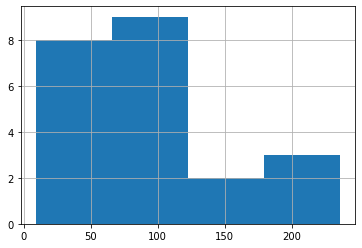

In [0]:


import matplotlib.pyplot as plt
nearby_venues_char['total likes'].hist(bins=4)
plt.show()

Raleigh Dataframe

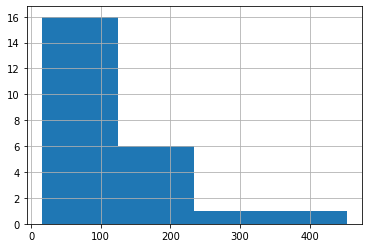

In [0]:
nearby_venues_raleigh['total likes'].hist(bins=4)
plt.show()

Based on no. of counts for each type of category, bar plot is drawn to see which type of restaurants are more common in both cities based on the data we obtained.

Below is the Bar plot for Raleigh. We can see that Italian type of Restaurant is found to be most common in Raleigh

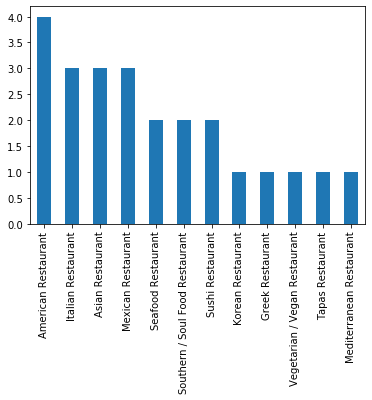

In [0]:
nearby_venues_raleigh['categories'].value_counts().plot(kind='bar')

Below is bar plot based on Charlotte data, we found American type and general restaurant with no particular category  are common in Charlotte

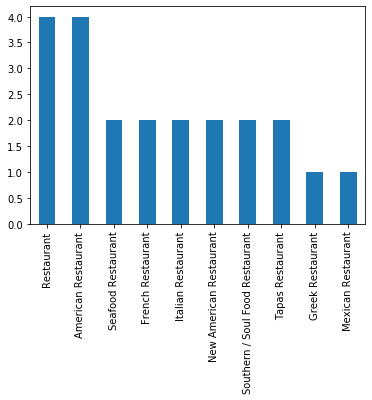

In [0]:
nearby_venues_char['categories'].value_counts().plot(kind='bar')

**Making 4 categories to categorize Raleigh and Charlotte data based on no. of Likes Restaurants received. Here, High rated, above avg rated, below average rated and poor rated category are used for the no. of likes falling in the range of 80<, 50-80,25-50, 25>.**
 

In [0]:
# let's set up a function that will re-categorize our restaurants based on likes

def conditions(s):
    if s['total likes']<=25:
        return 'poor rated'
    if s['total likes']<=50:
        return 'below avg rated'
    if s['total likes']<=80:
        return 'above avg rated'
    if s['total likes']>80:
        return 'high rated'

nearby_venues_char['Rating']=nearby_venues_char.apply(conditions, axis=1)
nearby_venues_char.head()

,name,id,categories,lat,lng,total likes,Rating
2,The Capital Grille,4b05863ef964a520f45922e3,American Restaurant,35.228216,-80.841974,96,high rated
4,Dandelion Market,4b466381f964a5206f1f26e3,Tapas Restaurant,35.228656,-80.842479,236,high rated
5,Vapiano,4e2ffb921838f1c552ca5f70,Italian Restaurant,35.226234,-80.844124,208,high rated
7,5 Church,4f8b5454e4b00a6263a38774,New American Restaurant,35.228548,-80.843054,212,high rated
11,Aria Tuscan Grill,4bb14a46f964a520fa893ce3,Italian Restaurant,35.226615,-80.842317,85,high rated


In [0]:
nearby_venues_raleigh['Rating']=nearby_venues_raleigh.apply(conditions, axis=1)
nearby_venues_raleigh.head()

,name,id,categories,lat,lng,total likes,Rating
5,Sitti,4ad93789f964a520261921e3,Mediterranean Restaurant,35.778237,-78.638266,231,high rated
7,Centro,4ad90386f964a5201d1721e3,Mexican Restaurant,35.779236,-78.638264,125,high rated
8,Gravy,4a592915f964a520d6b81fe3,Italian Restaurant,35.778482,-78.638143,139,high rated
10,Death & Taxes,54a1adbe498e54b4407ce331,American Restaurant,35.778245,-78.640375,64,above avg rated
14,Bida Manda Laotian Restaurant and Bar,4ee404309911944900b07ad5,Asian Restaurant,35.777227,-78.636812,262,high rated


Below visualization represents that there are more differences in high rated restaurants and restaurant with other 3 rated group in Raleigh as compared to Charlotte. Most of the restaurants received high rating in both the cities.

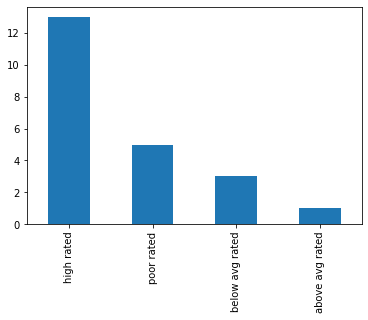

In [0]:
nearby_venues_char['Rating'].value_counts().plot(kind='bar')

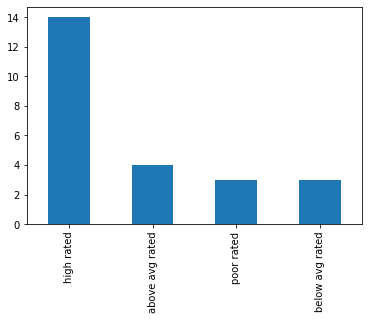

In [0]:
nearby_venues_raleigh['Rating'].value_counts().plot(kind='bar')

Creating dummy variables for the no. of likes and the restaurant categories in Raleigh.

In [0]:
# one hot encoding
Raleigh_onehot = pd.get_dummies(nearby_venues_raleigh[['categories', 'Rating']], prefix="", prefix_sep="")

# adding neighborhood column back to dataframe
Raleigh_onehot['Name'] = nearby_venues_raleigh['name'] 

# moving neighborhood column to the first column
fixed_columns1 = [Raleigh_onehot.columns[-1]] + list(Raleigh_onehot.columns[:-1])
Raleigh_onehot = Raleigh_onehot[fixed_columns1]

Raleigh_onehot.head()

,Name,American Restaurant,Asian Restaurant,Greek Restaurant,Italian Restaurant,Korean Restaurant,Mediterranean Restaurant,Mexican Restaurant,Seafood Restaurant,Southern / Soul Food Restaurant,Sushi Restaurant,Tapas Restaurant,Vegetarian / Vegan Restaurant,above avg rated,below avg rated,high rated,poor rated
5,Sitti,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
7,Centro,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
8,Gravy,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
10,Death & Taxes,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
14,Bida Manda Laotian Restaurant and Bar,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


Creating dummy variables for the no. of likes and the restaurant categories in Charlotte.

In [0]:
# one hot encoding
Char_onehot = pd.get_dummies(nearby_venues_char[['categories', 'Rating']], prefix="", prefix_sep="")

# adding neighborhood column back to dataframe
Char_onehot['Name'] = nearby_venues_char['name'] 

# moving neighborhood column to the first column
fixed_columns2 = [Char_onehot.columns[-1]] + list(Char_onehot.columns[:-1])
Char_onehot = Char_onehot[fixed_columns2]

Char_onehot

,Name,American Restaurant,French Restaurant,Greek Restaurant,Italian Restaurant,Mexican Restaurant,New American Restaurant,Restaurant,Seafood Restaurant,Southern / Soul Food Restaurant,Tapas Restaurant,above avg rated,below avg rated,high rated,poor rated
2,The Capital Grille,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,Dandelion Market,0,0,0,0,0,0,0,0,0,1,0,0,1,0
5,Vapiano,0,0,0,1,0,0,0,0,0,0,0,0,1,0
7,5 Church,0,0,0,0,0,1,0,0,0,0,0,0,1,0
11,Aria Tuscan Grill,0,0,0,1,0,0,0,0,0,0,0,0,1,0
14,Rooster's Wood Fired Kitchen II,1,0,0,0,0,0,0,0,0,0,0,0,1,0
25,The King's Kitchen,0,0,0,0,0,0,0,0,1,0,0,0,1,0
26,Stoke,0,0,0,0,0,0,1,0,0,0,0,1,0,0
27,The Cellar,0,0,0,0,0,0,1,0,0,0,0,1,0,0
38,Eddie V's Prime Seafood,0,0,0,0,0,0,0,1,0,0,0,0,0,1


Performing **K-means clustering** to classify both data

In [0]:
cluster_char = Char_onehot.drop('Name', axis=1)

k_clusters = 4


kmeansC = KMeans(n_clusters=k_clusters, random_state=0).fit(cluster_char)


kmeansC.labels_

array([2, 1, 1, 1, 1, 2, 1, 3, 3, 0, 3, 0, 0, 0, 1, 0, 0, 1, 2, 1, 2, 1],
      dtype=int32)

In [0]:
nearby_venues_char['label'] = kmeansC.labels_
nearby_venues_char

,name,id,categories,lat,lng,total likes,Rating,label
2,The Capital Grille,4b05863ef964a520f45922e3,American Restaurant,35.228216,-80.841974,96,high rated,2
4,Dandelion Market,4b466381f964a5206f1f26e3,Tapas Restaurant,35.228656,-80.842479,236,high rated,1
5,Vapiano,4e2ffb921838f1c552ca5f70,Italian Restaurant,35.226234,-80.844124,208,high rated,1
7,5 Church,4f8b5454e4b00a6263a38774,New American Restaurant,35.228548,-80.843054,212,high rated,1
11,Aria Tuscan Grill,4bb14a46f964a520fa893ce3,Italian Restaurant,35.226615,-80.842317,85,high rated,1
14,Rooster's Wood Fired Kitchen II,4f516ba8e4b063296bf04765,American Restaurant,35.226856,-80.841229,90,high rated,2
25,The King's Kitchen,4bd07af1caff952185dfcef0,Southern / Soul Food Restaurant,35.228093,-80.844206,98,high rated,1
26,Stoke,57a56d1f498e5952a14f86f4,Restaurant,35.228057,-80.843475,33,below avg rated,3
27,The Cellar,55a42c96498e793e0e13b18c,Restaurant,35.229240,-80.839710,44,below avg rated,3
38,Eddie V's Prime Seafood,5ae7e6746bdee6002c84ed22,Seafood Restaurant,35.226875,-80.843260,9,poor rated,0


## **Seeing clusters on Map using folium library**

In [0]:
map_clusters1 = folium.Map(location=[latitude_c, longitude_c], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i+x+(i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nearby_venues_char['lat'], nearby_venues_char['lng'], nearby_venues_char['name'], nearby_venues_char['label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters1)
       
map_clusters1
# Map for Charlotte city

Cluster 0 and 3 represents High rated Restaurants in Charlotte

In [0]:
nearby_venues_char.loc[ (nearby_venues_char['label']==0)|  (nearby_venues_char['label']==3) ]

,name,id,categories,lat,lng,total likes,Rating,label
26,Stoke,57a56d1f498e5952a14f86f4,Restaurant,35.228057,-80.843475,33,below avg rated,3
27,The Cellar,55a42c96498e793e0e13b18c,Restaurant,35.229240,-80.839710,44,below avg rated,3
38,Eddie V's Prime Seafood,5ae7e6746bdee6002c84ed22,Seafood Restaurant,35.226875,-80.843260,9,poor rated,0
40,Coco and the Director,57a85cb7498ebb2205737e6d,Restaurant,35.227684,-80.843548,37,below avg rated,3
44,La Belle Helene,5b639c99cabcff002cbe11b1,French Restaurant,35.225283,-80.845659,18,poor rated,0
49,Bentley's Restaurant on 27,4b05863ef964a520e95922e3,French Restaurant,35.224956,-80.843364,24,poor rated,0
51,Que Onda Tacos + Tequila,584365c79850a03d8398144e,Mexican Restaurant,35.229213,-80.845517,16,poor rated,0
63,Malabar,4f02453e30f899233495e903,Tapas Restaurant,35.228324,-80.841404,24,poor rated,0
65,McCormick & Schmick's,4b2ac7a6f964a52079af24e3,Seafood Restaurant,35.226437,-80.844560,67,above avg rated,0


Cluster 2 represents Poor-rated restaurants in Charlotte 

In [0]:
nearby_venues_char.loc[nearby_venues_char['label']==2]

,name,id,categories,lat,lng,total likes,Rating,label
2,The Capital Grille,4b05863ef964a520f45922e3,American Restaurant,35.228216,-80.841974,96,high rated,2
14,Rooster's Wood Fired Kitchen II,4f516ba8e4b063296bf04765,American Restaurant,35.226856,-80.841229,90,high rated,2
80,Mimosa Grill,4b05863bf964a520775922e3,American Restaurant,35.224981,-80.845958,101,high rated,2
93,Alexander Michael's,4b05863ef964a520f35922e3,American Restaurant,35.233657,-80.840755,110,high rated,2


Cluster 1 represents below average rated restaurants in Charlotte

In [0]:
nearby_venues_char.loc[nearby_venues_char['label']==1]

,name,id,categories,lat,lng,total likes,Rating,label
4,Dandelion Market,4b466381f964a5206f1f26e3,Tapas Restaurant,35.228656,-80.842479,236,high rated,1
5,Vapiano,4e2ffb921838f1c552ca5f70,Italian Restaurant,35.226234,-80.844124,208,high rated,1
7,5 Church,4f8b5454e4b00a6263a38774,New American Restaurant,35.228548,-80.843054,212,high rated,1
11,Aria Tuscan Grill,4bb14a46f964a520fa893ce3,Italian Restaurant,35.226615,-80.842317,85,high rated,1
25,The King's Kitchen,4bd07af1caff952185dfcef0,Southern / Soul Food Restaurant,35.228093,-80.844206,98,high rated,1
60,Mert’s Heart & Soul Restaurant,4b05863ff964a520345a22e3,Southern / Soul Food Restaurant,35.227318,-80.840130,168,high rated,1
75,Duckworth's Grill & Taphouse,54ecae87498ec256aee9450d,Restaurant,35.229240,-80.839710,121,high rated,1
82,Little Village Grill,4b21405cf964a520033924e3,Greek Restaurant,35.232023,-80.848767,82,high rated,1
95,Fahrenheit,53113efb498e59275ccb1fdd,New American Restaurant,35.222547,-80.841022,178,high rated,1


In [0]:
cluster_Raleigh = Raleigh_onehot.drop('Name', axis=1)

k_clusters = 4


kmeansR = KMeans(n_clusters=k_clusters, random_state=0).fit(cluster_Raleigh)


kmeansR.labels_

array([0, 0, 0, 3, 0, 0, 1, 0, 3, 1, 2, 0, 2, 3, 1, 0, 0, 0, 3, 1, 0, 0,
       0, 0], dtype=int32)

In [0]:
nearby_venues_raleigh['label'] = kmeansR.labels_
nearby_venues_raleigh.head()

,name,id,categories,lat,lng,total likes,Rating,label
5,Sitti,4ad93789f964a520261921e3,Mediterranean Restaurant,35.778237,-78.638266,231,high rated,0
7,Centro,4ad90386f964a5201d1721e3,Mexican Restaurant,35.779236,-78.638264,125,high rated,0
8,Gravy,4a592915f964a520d6b81fe3,Italian Restaurant,35.778482,-78.638143,139,high rated,0
10,Death & Taxes,54a1adbe498e54b4407ce331,American Restaurant,35.778245,-78.640375,64,above avg rated,3
14,Bida Manda Laotian Restaurant and Bar,4ee404309911944900b07ad5,Asian Restaurant,35.777227,-78.636812,262,high rated,0


In [0]:
map_clusters2 = folium.Map(location=[latitude_r, longitude_r], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i+x+(i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nearby_venues_raleigh['lat'], nearby_venues_raleigh['lng'], nearby_venues_raleigh['name'], nearby_venues_raleigh['label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters2)
       
map_clusters2
#Map for Raleigh

Cluster 0 represents high rated restaurants in Raleigh

In [0]:
nearby_venues_raleigh.loc[ nearby_venues_raleigh['label']==0 ]

,name,id,categories,lat,lng,total likes,Rating,label
5,Sitti,4ad93789f964a520261921e3,Mediterranean Restaurant,35.778237,-78.638266,231,high rated,0
7,Centro,4ad90386f964a5201d1721e3,Mexican Restaurant,35.779236,-78.638264,125,high rated,0
8,Gravy,4a592915f964a520d6b81fe3,Italian Restaurant,35.778482,-78.638143,139,high rated,0
14,Bida Manda Laotian Restaurant and Bar,4ee404309911944900b07ad5,Asian Restaurant,35.777227,-78.636812,262,high rated,0
19,Beasley's Chicken + Honey,4e091acc1f6e21103396e069,Southern / Soul Food Restaurant,35.776968,-78.638175,453,high rated,0
27,Sono,4ad90968f964a520651721e3,Sushi Restaurant,35.775919,-78.638562,146,high rated,0
34,Taverna Agora,5577a05f498e75efda31c6a9,Greek Restaurant,35.780776,-78.644406,93,high rated,0
54,Oak City Meatball Shoppe,516798e0e4b0cda68217b5ed,Italian Restaurant,35.775520,-78.637234,126,high rated,0
55,Whiskey Kitchen,57a7bf38498ea30d9431bde1,Southern / Soul Food Restaurant,35.776861,-78.642111,89,high rated,0
56,42nd St Oyster Bar,4ae6edcaf964a5208ea721e3,Seafood Restaurant,35.782864,-78.646165,202,high rated,0


Cluster 1 represents above average rated restaurants in Raleigh

In [0]:
nearby_venues_raleigh.loc[ nearby_venues_raleigh['label']==1 ]

,name,id,categories,lat,lng,total likes,Rating,label
23,Trophy Tap & Table,588663ddd60c8b2e0e1b1527,American Restaurant,35.777417,-78.638184,46,below avg rated,1
32,St. Roch Fine Oysters + Bar,590a66230f013c70e0a0c5f1,Seafood Restaurant,35.777494,-78.638153,16,poor rated,1
46,The District,57f2d3e8498e33363fc556f5,American Restaurant,35.779788,-78.643572,23,poor rated,1
65,Mofu Shoppe,5916326a396de017a362ff17,Korean Restaurant,35.775916,-78.636603,22,poor rated,1


Cluster 2 represents below average rated restaurants in Raleigh

In [0]:
nearby_venues_raleigh.loc[ nearby_venues_raleigh['label']==2 ]

,name,id,categories,lat,lng,total likes,Rating,label
33,City Market Sushi,58581f96076be1032aaa07f4,Sushi Restaurant,35.776276,-78.635776,31,below avg rated,2
36,Gringo A Go Go,527e482c498e9cdc1c97aefc,Mexican Restaurant,35.781287,-78.634479,39,below avg rated,2


Cluster 3 represents poor rated restaurants in Raleigh

In [0]:
nearby_venues_raleigh.loc[ nearby_venues_raleigh['label']==3 ]

,name,id,categories,lat,lng,total likes,Rating,label
10,Death & Taxes,54a1adbe498e54b4407ce331,American Restaurant,35.778245,-78.640375,64,above avg rated,3
29,Garland,51940a5d498e9111bc706456,Asian Restaurant,35.776947,-78.639887,64,above avg rated,3
45,Second Empire Restaurant & Tavern,4aeb2a4cf964a52033bf21e3,American Restaurant,35.781020,-78.644680,54,above avg rated,3
60,Caffé Luna,4ad9fa9af964a520ab1c21e3,Italian Restaurant,35.778086,-78.636749,55,above avg rated,3


# Enriching Data with Yelp Reviews by procession JSON file

In [0]:
import gc
from collections import Counter # for counting commong words
plt.style.use('fivethirtyeight') # use ggplot ploting style
import seaborn as sns # visualization 
from wordcloud import WordCloud, STOPWORDS # this module is for making wordcloud in python
import re # regular expression
import string # for finding punctuation in text
import nltk # preprocessing text
from textblob import TextBlob
import plotly
import plotly.offline as py # make offline 
py.init_notebook_mode(connected=True)
import plotly.tools as tls
import plotly.graph_objs as go
from plotly.graph_objs import *
import plotly.tools as tls
import plotly.figure_factory as fig_fact
# remove war
import warnings
warnings.filterwarnings('ignore')
# this will allow ploting inside the notebook
%matplotlib inline
import numpy as np
import pandas as pd
import os
import json
import matplotlib as mpl
import seaborn as sns
import missingno as msno
from sklearn.decomposition import PCA
inline_rc = dict(mpl.rcParams)

In [0]:
print(os.listdir("/Users/yashbajoria/Downloads/yelp-dataset"))

['yelp_academic_dataset_checkin.json', 'yelp_academic_dataset_tip.json', 'Dataset_Agreement.pdf', 'yelp_academic_dataset_review.json', 'yelp_academic_dataset_business.json', 'yelp_academic_dataset_user.json']


## Reading Data

In [0]:

users = []
with open('/Users/yashbajoria/Downloads/yelp-dataset/yelp_academic_dataset_business.json') as fl:
    for i, line in enumerate(fl):
        users.append(json.loads(line))
        
df = pd.DataFrame(users)
df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh...","{'Monday': '10:0-18:0', 'Tuesday': '11:0-20:0'..."
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,1,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","Health & Medical, Fitness & Instruction, Yoga,...",None
2,XNoUzKckATkOD1hP6vghZg,Felinus,3554 Rue Notre-Dame O,Montreal,QC,H4C 1P4,45.479984,-73.580070,5.0,5,1,None,"Pets, Pet Services, Pet Groomers",None
3,6OAZjbxqM5ol29BuHsil3w,Nevada House of Hose,1015 Sharp Cir,North Las Vegas,NV,89030,36.219728,-115.127725,2.5,3,0,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Hardware Stores, Home Services, Building Suppl...","{'Monday': '7:0-16:0', 'Tuesday': '7:0-16:0', ..."
4,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,AZ,85205,33.428065,-111.726648,4.5,26,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Home Services, Plumbing, Electricians, Handyma...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-16:0', '..."


## Visualizing top business categories in the dataframe

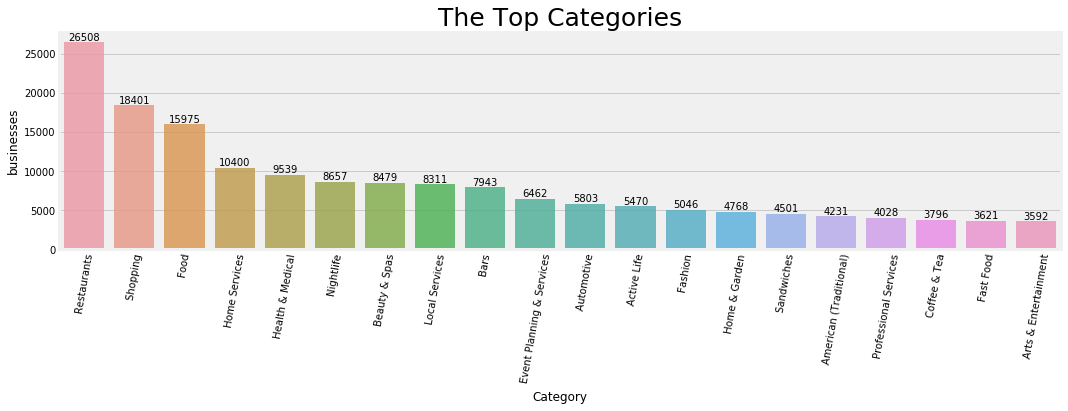

In [0]:
business_categories = ''.join(df['categories'].astype('str'))

cats=pd.DataFrame(business_categories.split(','),columns=['categories'])

#prep for chart
x=cats.categories.value_counts()

x=x.sort_values(ascending=False)
x=x.iloc[0:20]

#chart
plt.figure(figsize=(16,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("The Top Categories",fontsize=25)
locs, labels = plt.xticks()
plt.setp(labels, rotation=80)
plt.ylabel('businesses', fontsize=12)
plt.xlabel('Category', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

## Filtering data to extract restaurants related data only 

In [0]:
food_cat= ['Restaurants', 'Food','Bars','Sandwiches','Coffee&Tea','Fast Food']
restaurants = df[df['categories'].isin(food_cat)]

## Filtering data to extract data of North Carolina State then specifically Charlotte

In [0]:
restaurants_nc= restaurants[restaurants['state']=='NC']
restaurants_char= restaurants_nc[restaurants_nc['city']=='Charlotte']
colname= ['business_id','name','latitude','longitude','stars','review_count','categories']
restaurants_char=restaurants_char.filter(colname)
restaurants_char

,business_id,name,latitude,longitude,stars,review_count,categories
11623,iDdDQDyvjYJ-YxeUjBMFsg,City Tavern,35.199979,-80.842334,3.5,4,Restaurants
12245,jGC-7KSSr4a6kceTehcSpA,SouthEast Crab Feast,35.150282,-80.850352,2.0,12,Food
34031,xxJMwfmcRFdQXbJJetntlw,Sub Station II,35.135719,-80.878744,3.5,3,Restaurants
77077,LAswzVTnT3uCvnKr-SwxEg,Hmshost,35.220559,-80.943874,2.0,5,Restaurants
135526,lRkmUoo9gEcDq6_GZkdlrg,Havana Cuban Cuisine,35.227966,-80.844061,2.5,6,Food
140953,dlt1ugrobTjdjX6U73gbsw,Carolina Grill,35.137223,-80.734594,3.5,4,Restaurants
146464,liLRXHaS5x4vy8EJq5fh9g,Arthurs's At Wachovia,35.223805,-80.844616,3.0,5,Restaurants
176261,r7S7Dbq6AqSrne2WgoXohQ,Harper's Restaurant,35.208801,-80.840503,4.5,3,Restaurants
202429,htukE-iB6K8Yn2q5W4bI_A,Cheese Mo'z Coal Fired Pizza,35.053554,-80.811620,2.5,7,Restaurants


We see there is no data of Raleigh in yelp review dataset

## Adding Rating as new feature similar as above

In [0]:
def conditions(s):
    if s['stars']<=2:
        return 'poor rated'
    if (s['stars']<=2.5) & (s['stars'] > 2):
        return 'below avg rated'
    if s['stars']<=3.5:
        return 'above avg rated'
    if s['stars']>=4:
        return 'high rated'

restaurants_char['Rating']=restaurants_char.apply(conditions, axis=1)
restaurants_char=restaurants_char.rename(columns={"business_id": "id", "latitude": "lat", 'longitude':'lng'})
restaurants_char

,id,name,lat,lng,stars,review_count,categories,Rating
11623,iDdDQDyvjYJ-YxeUjBMFsg,City Tavern,35.199979,-80.842334,3.5,4,Restaurants,above avg rated
12245,jGC-7KSSr4a6kceTehcSpA,SouthEast Crab Feast,35.150282,-80.850352,2.0,12,Food,poor rated
34031,xxJMwfmcRFdQXbJJetntlw,Sub Station II,35.135719,-80.878744,3.5,3,Restaurants,above avg rated
77077,LAswzVTnT3uCvnKr-SwxEg,Hmshost,35.220559,-80.943874,2.0,5,Restaurants,poor rated
135526,lRkmUoo9gEcDq6_GZkdlrg,Havana Cuban Cuisine,35.227966,-80.844061,2.5,6,Food,below avg rated
140953,dlt1ugrobTjdjX6U73gbsw,Carolina Grill,35.137223,-80.734594,3.5,4,Restaurants,above avg rated
146464,liLRXHaS5x4vy8EJq5fh9g,Arthurs's At Wachovia,35.223805,-80.844616,3.0,5,Restaurants,above avg rated
176261,r7S7Dbq6AqSrne2WgoXohQ,Harper's Restaurant,35.208801,-80.840503,4.5,3,Restaurants,high rated
202429,htukE-iB6K8Yn2q5W4bI_A,Cheese Mo'z Coal Fired Pizza,35.053554,-80.811620,2.5,7,Restaurants,below avg rated


**I performed data formatting in order to match the columns of previous charlotte dataset so that we can merge both dataframes.**

## One hot encoding to perform unsuperivised machine learning classification

In [0]:
# one hot encoding
Charonehot = pd.get_dummies(restaurants_char[['categories', 'Rating']], prefix="", prefix_sep="")

# adding neighborhood column back to dataframe
Charonehot['Name'] = restaurants_char['name'] 

# moving neighborhood column to the first column
fixed_columns2 = [Charonehot.columns[-1]] + list(Charonehot.columns[:-1])
Charonehot = Charonehot[fixed_columns2]

cluster_charl = Charonehot.drop('Name', axis=1)

k_clusters = 4

## Performing k mean clustering and adding clusters as new feature to dataset to visualize on map
kmeansCh = KMeans(n_clusters=k_clusters, random_state=0).fit(cluster_charl)
kmeansCh.labels_

restaurants_char['label'] = kmeansCh.labels_
restaurants_char.shape

(9, 9)

**Merging both dataframes**

In [0]:
combined_char= pd.concat([nearby_venues_char, restaurants_char], axis=0)

In [0]:
combined_char=combined_char.drop(['total likes', 'stars','review_count'], axis=1)

In [0]:
combined_char=combined_char.reset_index()
combined_char=combined_char.drop(['index'], axis=1)

**Transforming latitude and longitude data as Coordinates(X,Y) for further querying data**

In [0]:
restaurants_coord= []
for i in combined_char.index:
    point = (combined_char.lat[i],combined_char.lng[i])
    restaurants_coord.append(point)
combined_char['Coordinates'] = restaurants_coord 



In [0]:
restaurants_coords= []
for i in nearby_venues_raleigh.index:
    points = (nearby_venues_raleigh.loc[i,'lat'],nearby_venues_raleigh.loc[i,'lng'])
    restaurants_coords.append(points)
nearby_venues_raleigh['Coordinates'] = restaurants_coords 
nearby_venues_raleigh=nearby_venues_raleigh.reset_index()
nearby_venues_raleigh=nearby_venues_raleigh.drop(['index'], axis=1)

In [0]:
nearby_venues_raleigh= pd.concat([nearby_venues_raleigh, combined_char], axis=0)

## Creating search query

**In this restaurant query, one can search for restaurants in both cities by querying the data giving specific cuisine type and rating desired and this will automatically search your current location and filter restaurants based on your choices and return their name, cuisine type, distance from your loaction and map visualizing the restaurants recommended on map.**

In [0]:
import geocoder
from scipy import spatial

In [0]:
def restaurant_query(Category, Rating):
    #extracting coordinates of current location using geocoder
    g = geocoder.ip('me')
    #using scipy spatial KD trees to query the KD tree to find nearest restaurants to current location
    tree = spatial.KDTree(nearby_venues_raleigh['Coordinates'].tolist())
    distance= tree.query(g.latlng)[0] # distance from current location
    location= tree.query(g.latlng)[1] # location in dataset
    #filtering dataframe with location extracted by kd query
    selected_restaurantR = nearby_venues_raleigh.iloc[location]
    selected_restaurantR=selected_restaurantR.to_frame()
    selected_restaurantR=selected_restaurantR.T
    # Condition to extract restaurants of desired type
    if (Category in selected_restaurantR['categories'].tolist()) & (Rating in selected_restaurantR['Rating'].tolist()): 
        selected_restaurantR['Distance'] = distance
        
        
    # Visualizing on Map
        map_clustersR = folium.Map(location=g.latlng, zoom_start=15)

        # set color scheme for the clusters
        x = np.arange(k_clusters)
        ys = [i+x+(i*x)**2 for i in range(k_clusters)]
        colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
        rainbow = [colors.rgb2hex(i) for i in colors_array]

        # add markers to the map
        markers_colors = []
        for lat, lon, poi, cluster in zip(selected_restaurantR['lat'], selected_restaurantR['lng'], selected_restaurantR['name'], selected_restaurantR['label']):
            label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
            folium.CircleMarker(
                [lat, lon],
                radius=5,
                popup=label,
                color=rainbow[cluster-1],
                fill=True,
                fill_color=rainbow[cluster-1],
                fill_opacity=0.7).add_to(map_clustersR)

        print(selected_restaurantR[['name','categories','Distance']])
        return map_clustersR
    else : 
        print('no match')
    

In [0]:
restaurant_query('Italian Restaurant', 'high rated')

                        name          categories  Distance
15  Oak City Meatball Shoppe  Italian Restaurant  0.003682
